In [1]:
using MatrixNetworks
using Distributions
using Clustering
using NPZ
using BenchmarkTools, Compat
using DelimitedFiles
using SparseArrays
using Printf
using LinearAlgebra
using Plots
using SphericalGraphEmbedding

### Compute NMI between retreived and true community

In [2]:
## Compute NMI for each graph

path="LFR_data/"
n_graphs=10

# Set parameters of simulations

n_it_PPM = 30000;
t = 1e-10;
n_clusters = 20;
r0 = 20;

# Specify here the number of times vector partition is repeated
n_it_Vec_Partition = 10;
# we advise : n_it_Vec_Partition = 100;

n_updates = 100; # max total by default
#shape = "Ellipsoidal";
shape = "Spherical"

n_rep = 3;
mus=zeros(Float64,n_graphs)
NMIs=zeros(Float64,n_graphs,n_rep)
NMIs_louvain=zeros(Float64,n_graphs)

for g=1:n_graphs
    println("\n========== Graph $g/$(n_graphs) ==========")
    
    # load communities
    community_true=readdlm(path*"communities"*string(g-1)*".txt",Int)
    community_louvain=readdlm(path*"louvain_communities"*string(g-1)*".txt",Int)

    # load graph
    edgeList=readdlm(path*"edgeList"*string(g-1)*".txt",Int)

    n_nodes=size(community_true)[1]
    n_edges=size(edgeList)[1]

    # construct sparse adjacency matrix from list of edges
    adj=sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
    adj=adj+adj' # only the upper triangular part of adjacency matrix was stored

    # keep only the largest connected component
    adj,vertices = largest_component(adj);
    
    community_true=community_true[vertices]
    community_true=rename_com_unique(community_true)
    
    community_louvain=community_louvain[vertices]
    community_louvain=rename_com_unique(community_louvain)

    # load parameters
    LFR_parameters=readdlm(path*"parameters"*string(g-1)*".txt")
    mu=parse(Float64, split(LFR_parameters[4],"=")[2]) # extract mixing marameter (not very robust)
    mus[g]=mu
    
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")
        
        # embed cluster
        _,community = @time sphere_embed_cluster(adj,n_it_PPM,t, n_clusters,n_it_Vec_Partition,n_updates,shape,r0)

        NMIs[g,j]=mutualinfo(community_true,community);
    end
    NMIs_louvain[g]=mutualinfo(community_true,community_louvain);
end




========== Graph 1/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 258 iterations
  0.451458 seconds (28.84 k allocations: 359.447 MiB, 12.50% gc time, 8.08% compilation time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 20
Number of updates: 1
Number of communities: 11
Modularity: 0.6587911708073676
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.40192710975268925, 0.2665474547863934, 0.17916165151207075, 0.09610624342361765, 0.05570717808935356]
 -------------------------------------------- 
  0.983946 seconds (1.04 M allocations: 429.922 MiB, 5.74% gc time, 54.53% compilation time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 345 iterations
  0.518019 seconds (9.01 k allocations: 479.439 MiB, 11.83% gc time)
 -------------- Clustering

[0.20858863408191122, 0.19092835631723323, 0.13965645789440004, 0.10804980392592602, 0.09690619408196766]
 -------------------------------------------- 
  0.515543 seconds (100.38 k allocations: 399.704 MiB, 8.27% gc time)

========== Graph 6/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 359 iterations
  1.367785 seconds (9.38 k allocations: 498.938 MiB, 7.09% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 20
Number of updates: 4
Number of communities: 5
Modularity: 0.18876865472425847
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.17601924199919738, 0.15713907514959677, 0.1364929600529301, 0.12676174440267252, 0.09951581156600788]
 -------------------------------------------- 
  1.432207 seconds (133.72 k allocations: 540.290 MiB, 6.77% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Po

dimension of embedding used for clustering: 20
Number of updates: 3
Number of communities: 7
Modularity: 0.1624355352223334
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.1565225142195834, 0.1477725862786579, 0.13509633416719805, 0.1096117795219661, 0.09650203301917464]
 -------------------------------------------- 
  0.546089 seconds (125.35 k allocations: 524.283 MiB, 9.21% gc time)


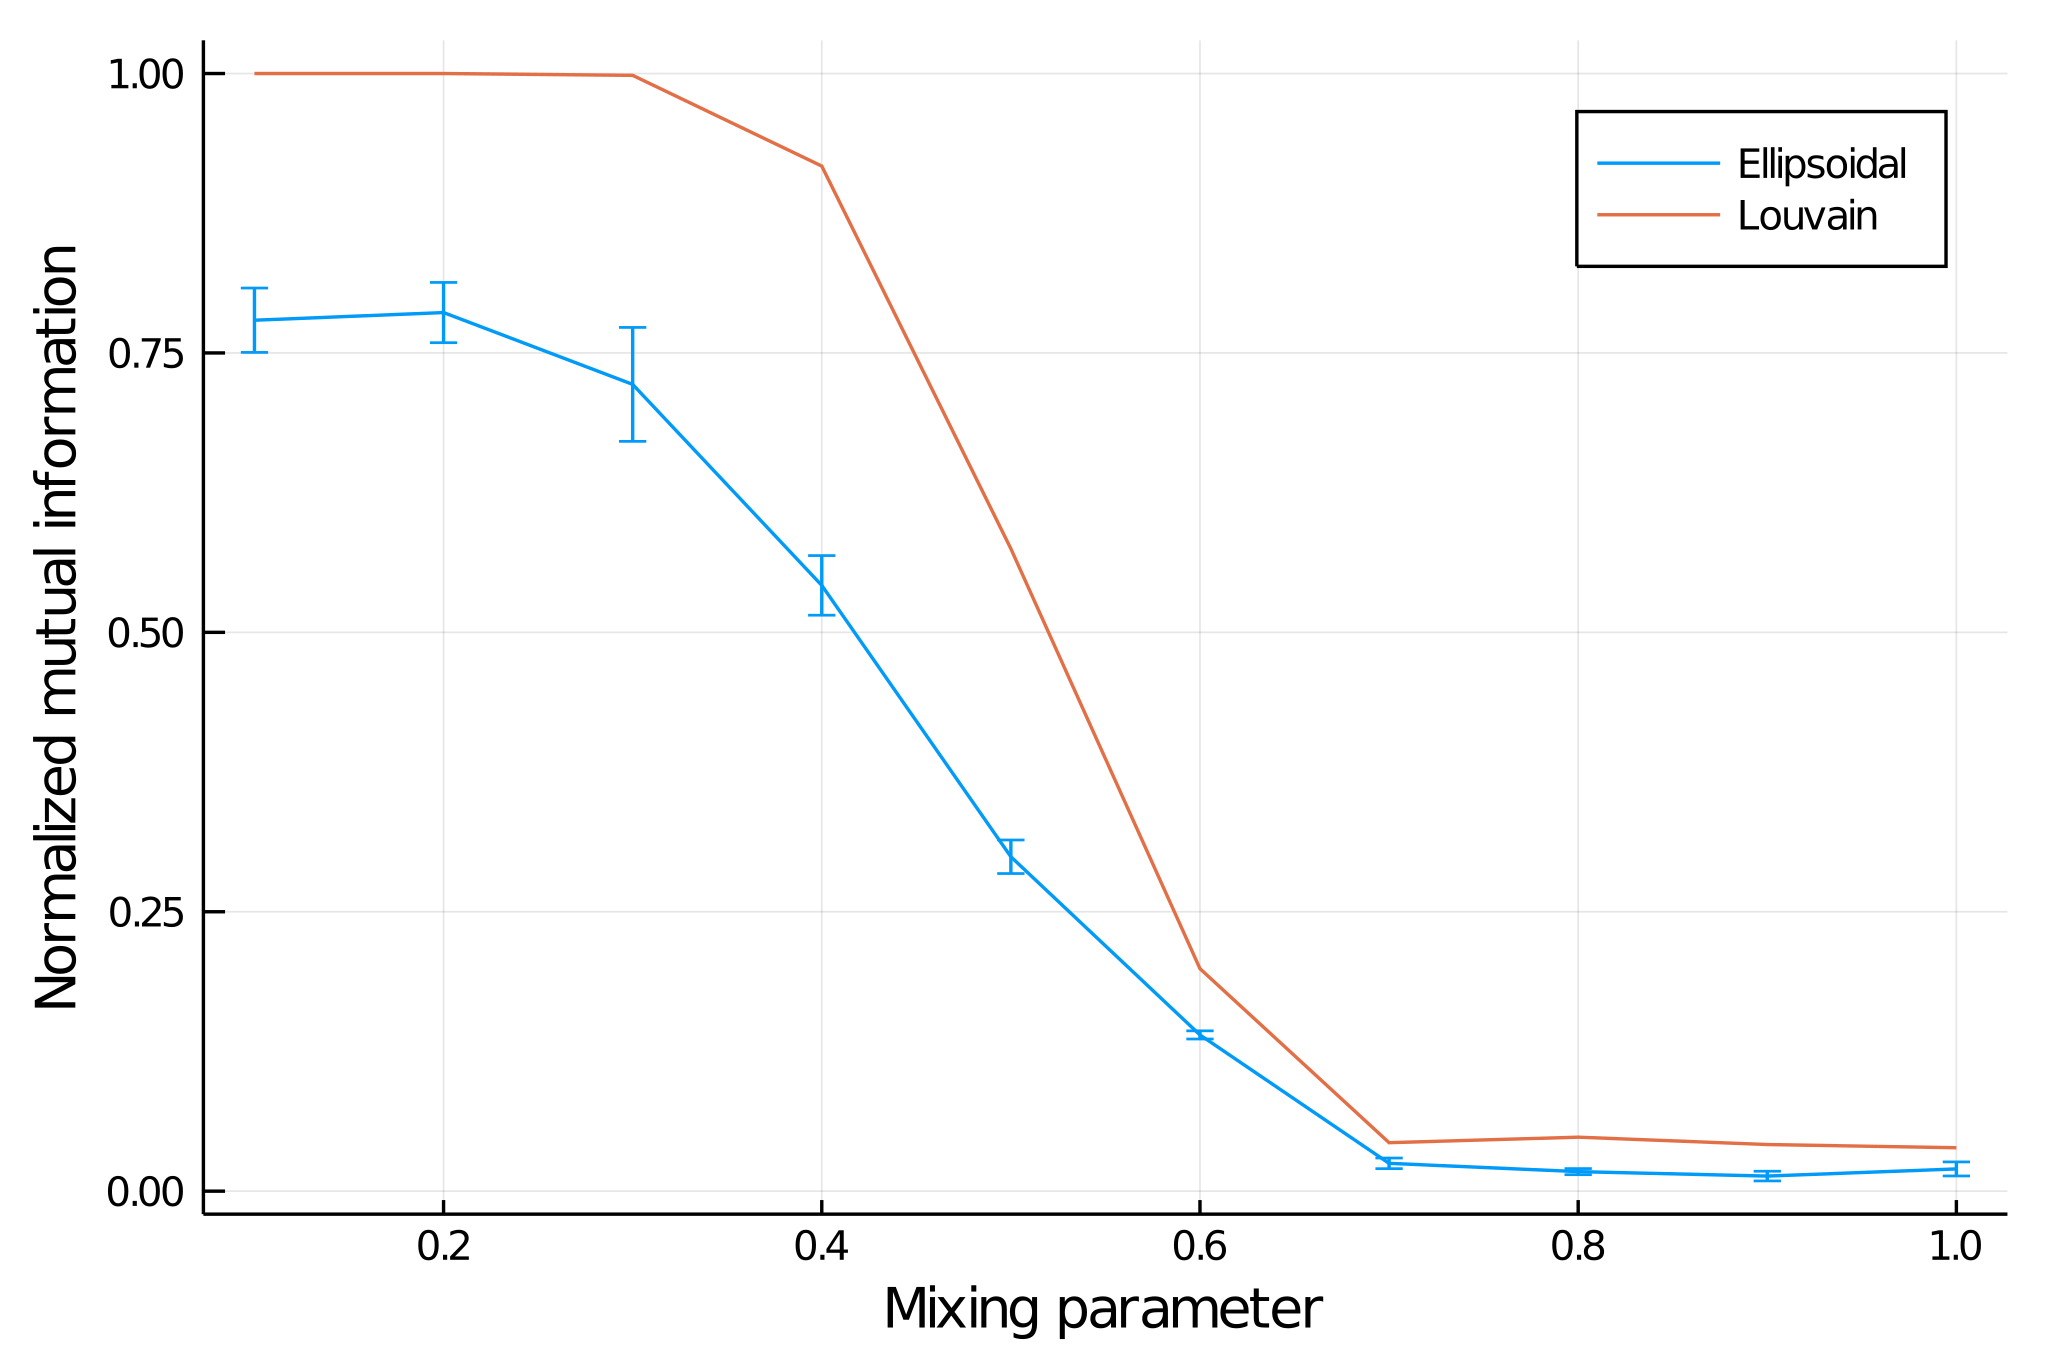

In [4]:
#######################################################################
# Plot Normalized mutual information vs Miwing parameter
#######################################################################
m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
plot(mus, m, yerror = s,
markerstrokecolor=:auto,
xlabel = "Mixing parameter",
ylabel = "Normalized mutual information",
labels = "Ellipsoidal")

plot!(mus, NMIs_louvain,
markerstrokecolor=:auto,
xlabel = "Mixing parameter",
ylabel = "Normalized mutual information",
labels = "Louvain")
savefig("./nmi.pdf")
plot!()
#######################################################################

### OLD CODE: Compute NMI between retreived and true community


========== Graph 1/10, mu=0.1, number_rep = 1 ==========
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 515 iterations
  0.656073 seconds (13.44 k allocations: 716.193 MiB, 15.43% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 20
Number of updates: 3
Number of communities: 15
Modularity: 0.8207706510838086
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.42333888395263175, 0.24925723224247245, 0.16376525548690468, 0.09988556243645351, 0.06371188454005668]
 -------------------------------------------- 
  0.690578 seconds (106.94 k allocations: 747.259 MiB, 15.45% gc time)

========== Graph 1/10, mu=0.1, number_rep = 2 ==========
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 345 iterations
  0.430736 seconds (9.01 k allocations: 479.439 MiB, 12.65% gc time)
 -------------- Clustering ------- 
dimension of embe

dimension of embedding used for clustering: 20
Number of updates: 6
Number of communities: 13
Modularity: 0.44735955628199764
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.23435068653696467, 0.2092581607493882, 0.16251076236329304, 0.1271977587746277, 0.0924475462213219]
 -------------------------------------------- 
  0.475870 seconds (172.48 k allocations: 495.096 MiB, 10.57% gc time)

========== Graph 6/10, mu=0.6, number_rep = 1 ==========
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 249 iterations
  0.292361 seconds (6.52 k allocations: 345.743 MiB, 11.26% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 20
Number of updates: 5
Number of communities: 15
Modularity: 0.33614570370503966
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21968992595697195, 0.15983216652345314, 0.15333586713960484

[0.170336318401893, 0.14207133964707283, 0.13107405823259055, 0.11261885841378132, 0.09620140701803559]
 -------------------------------------------- 
  0.532390 seconds (200.90 k allocations: 592.431 MiB, 11.16% gc time)

========== Graph 10/10, mu=1.0, number_rep = 3 ==========
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 218 iterations
  0.259020 seconds (5.71 k allocations: 302.571 MiB, 10.42% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 20
Number of updates: 13
Number of communities: 7
Modularity: 0.2135993162913497
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.17028921426692742, 0.14205669189034006, 0.13082690259926608, 0.11253333540231013, 0.09636542373357805]
 -------------------------------------------- 
  0.351513 seconds (221.35 k allocations: 373.081 MiB, 11.56% gc time)


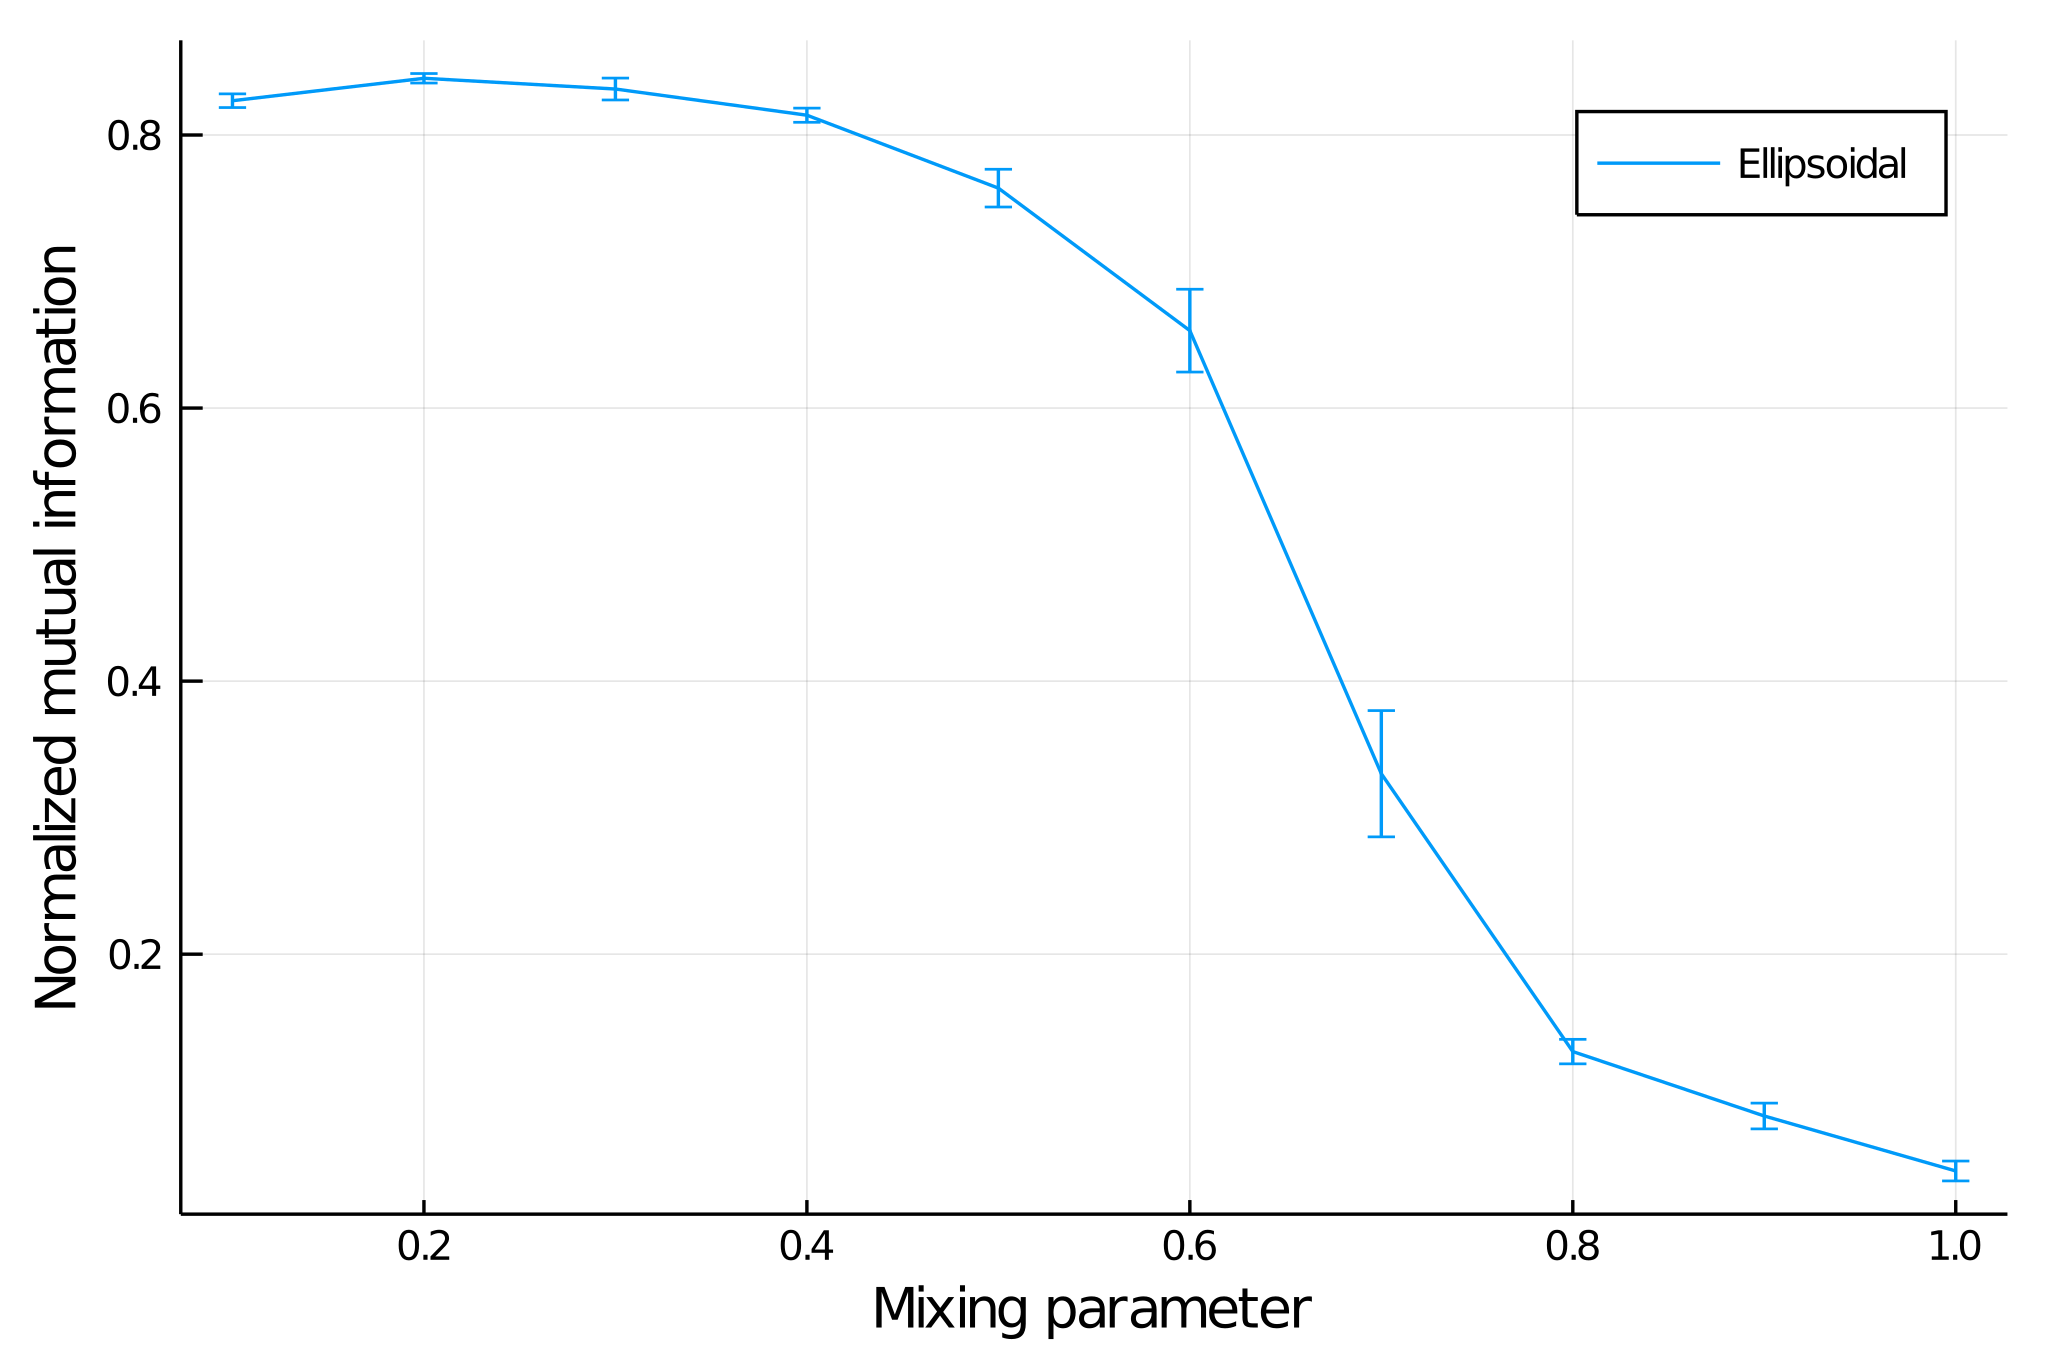

In [3]:
## Compute NMI for each graph

# Set parameters of simulations
mus=0.1:0.1:1 # values for the mixing parameter

n_it_PPM = 30000;
t = 1e-10;
n_clusters = 20;
r0 = 20;

# Specify here the number of times vector partition is repeated
n_it_Vec_Partition = 10;
# we advise : n_it_Vec_Partition = 100;

n_updates = 100; # max total by default
shape = "Ellipsoidal"; #shape = "Spherical"

n_rep = 3;
NMIs=zeros(Float64,length(mus),n_rep)


for i=1:length(mus)
    for j=1:n_rep
        println("\n========== Graph $i/$(length(mus)), mu=$(mus[i]), number_rep = $j ==========")
        
        # load graph data
        community0 = readdlm("Data/LFR_NMI/data"*string(mus[i])*".nmc"); # communities: .nmc
        adj = readdlm("Data/LFR_NMI/data"*string(mus[i])*".nse"); # network: *.nse
        
        # remove first line (infos) and third column (weights)
        adj = adj[2:end,1:2]
        adj = convert(Array{Float64,2},adj)

        community_true = convert(Array{Int64},community0[:,2])
        N = length(community_true);
        n_edge2 = size(adj)[1];

        adj = sparse(adj[:,1],adj[:,2],vec(ones(Int64,n_edge2,1)),N,N);
        adj = adj+adj' # Only the upper triangular part of A was stored

        adj,vertices = largest_component(adj);
        community_true=community_true[vertices]
        community_true=rename_com_unique(community_true)
        
        # embed cluster
        _,community = @time sphere_embed_cluster(adj,n_it_PPM,t, n_clusters,n_it_Vec_Partition,n_updates,shape,r0)

        NMIs[i,j]=mutualinfo(community_true,community);
    end
end
#######################################################################
# Plot Normalized mutual information vs Miwing parameter
#######################################################################
m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
plot(mus, m, yerror = s,
markerstrokecolor=:auto,
xlabel = "Mixing parameter",
ylabel = "Normalized mutual information",
labels = "Ellipsoidal")
#######################################################################



In [ ]:
x=1